In [50]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data.datasets import get_rotated_mnist_loaders, get_mnist_ood_loaders
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import n_classes, MNIST
from collections import defaultdict


In [51]:
param_dict = pickle.load(open("../checkpoints/MNIST/posterior_samples_seed_0_seed0_type_non-kernel-eigvals_params.pickle", "rb"))

In [52]:
param_dict.keys()

dict_keys(['posterior_samples'])

### Load all the models

In [53]:
swag_posterior_list = []
swag_posterior_list.append(pickle.load(open("../checkpoints/MNIST/baselines/SWAG_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
swag_posterior_list.append(pickle.load(open("../checkpoints/MNIST/baselines/SWAG_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
swag_posterior_list.append(pickle.load(open("../checkpoints/MNIST/baselines/SWAG_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])
# lr_posterior_list.append((pickle.load(open("../checkpoints/MNIST/posterior_samples_params.pickle", "rb"))['posterior_samples']))

last_layer_list = []
last_layer_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Subnetwork_baseline_0_seed_0_prec_1.0_params.pickle", "rb"))['posterior_samples'])
last_layer_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Subnetwork_baseline_1_seed_1_prec_1.0_params.pickle", "rb"))['posterior_samples'])
last_layer_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Subnetwork_baseline_2_seed_2_prec_1.0_params.pickle", "rb"))['posterior_samples'])

diag_list = []
diag_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Hutchinson_Diag_baseline_0_seed_0_prec_50.0_params.pickle", "rb"))['posterior_samples'])
diag_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Hutchinson_Diag_baseline_1_seed_1_prec_50.0_params.pickle", "rb"))['posterior_samples'])
diag_list.append(pickle.load(open("../checkpoints/MNIST/baselines/Hutchinson_Diag_baseline_2_seed_2_prec_50.0_params.pickle", "rb"))['posterior_samples'])

lr_posterior_list = []
lr_posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_seed_0_seed0_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])
lr_posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_seed_1_seed1_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])
lr_posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_seed_2_seed2_type_non-kernel-eigvals_params.pickle", "rb"))['posterior_samples'])
# lr_posterior_list.append((pickle.load(open("../checkpoints/MNIST/posterior_samples_params.pickle", "rb"))['posterior_samples']))

posterior_list = []
posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_baseline_seed_0_seed0_type_full-ggn_params.pickle", "rb"))['posterior_samples'])
posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_baseline_seed_1_seed1_type_full-ggn_params.pickle", "rb"))['posterior_samples'])
posterior_list.append(pickle.load(open("../checkpoints/MNIST/posterior_samples_baseline_seed_2_seed2_type_full-ggn_params.pickle", "rb"))['posterior_samples'])


param_list = []
param_list.append(pickle.load(open("../checkpoints/MNIST/LeNet/seed_0_seed0_params.pickle", "rb"))['params'])
param_list.append(pickle.load(open("../checkpoints/MNIST/LeNet/seed_1_seed1_params.pickle", "rb"))['params'])
param_list.append(pickle.load(open("../checkpoints/MNIST/LeNet/seed_2_seed2_params.pickle", "rb"))['params'])


In [54]:
model = LeNet(output_dim=10, activation="tanh")
model_fn = lambda p, x: model.apply(p, x)

### Rotated MNIST

In [55]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, lr_posterior) in enumerate(zip(param_list, lr_posterior_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


R-MNIST with distribution shift intensity 0


/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/geometric-laplace/geom/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9877, nll_mean: 0.0404, acc_mean: 0.9860, conf_std: 0.0011, nll_std: 0.0072, acc_std: 0.0016, brier_mean: 0.0220, ece_mean: 0.1462, mce_mean: 0.7730, brier_std: 0.0033, ece_std: 0.0112, mce_std: 0.0500
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9663, nll_mean: 0.1624, acc_mean: 0.9473, conf_std: 0.0042, nll_std: 0.0078, acc_std: 0.0041, brier_mean: 0.0790, ece_mean: 0.1767, mce_mean: 0.8584, brier_std: 0.0033, ece_std: 0.0162, mce_std: 0.0759
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.9155, nll_mean: 0.7897, acc_mean: 0.8113, conf_std: 0.0091, nll_std: 0.0203, acc_std: 0.0093, brier_mean: 0.3031, ece_mean: 0.2328, mce_mean: 0.7743, brier_std: 0.0093, ece_std: 0.0068, mce_std: 0.0359
R-M

In [56]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.5932, nll_mean: 3.6686, acc_mean: 0.1567, conf_std: 0.0020, nll_std: 0.1573, acc_std: 0.0308, brier_mean: 1.1617, ece_mean: 0.4358, mce_mean: 0.9838, brier_std: 0.0443, ece_std: 0.0272, mce_std: 0.0013
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.5942, nll_mean: 3.6991, acc_mean: 0.1507, conf_std: 0.0104, nll_std: 0.1830, acc_std: 0.0123, brier_mean: 1.1797, ece_mean: 0.4462, mce_mean: 0.9778, brier_std: 0.0241, ece_std: 0.0217, mce_std: 0.0055
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.5849, nll_mean: 3.9308, acc_mean: 0.1073, conf_std: 0.0224, nll_std: 0.2179, acc_std: 0.0154, brier_mean: 1.2232, ece_mean: 0.4776, mce_mean: 0.9737, brier_std: 

In [57]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lienarised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lienarised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lienarised[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9666, nll_mean: 0.2950, acc_mean: 0.9300, conf_std: 0.0023, nll_std: 0.0415, acc_std: 0.0043, brier_mean: 0.1111, ece_mean: 0.2392, mce_mean: 0.8625, brier_std: 0.0061, ece_std: 0.0318, mce_std: 0.0444
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9484, nll_mean: 0.7590, acc_mean: 0.8633, conf_std: 0.0060, nll_std: 0.1495, acc_std: 0.0109, brier_mean: 0.2229, ece_mean: 0.2670, mce_mean: 0.8448, brier_std: 0.0274, ece_std: 0.0373, mce_std: 0.0547
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.9130, nll_mean: 2.2195, acc_mean: 0.6800, conf_std: 0.0031, nll_std: 0.1595, acc_std: 0.0142, brier_mean: 0.5412, ece_mean: 0.3254, mce_mean: 0.7718, brier_std: 

In [58]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, swag_posterior) in enumerate(zip(param_list, swag_posterior_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="/dtu/p1/hroy/data/", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9927, nll_mean: 0.0322, acc_mean: 0.9887, conf_std: 0.0008, nll_std: 0.0014, acc_std: 0.0019, brier_mean: 0.0186, ece_mean: 0.1871, mce_mean: 0.9006, brier_std: 0.0012, ece_std: 0.0241, mce_std: 0.0406
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9747, nll_mean: 0.1160, acc_mean: 0.9587, conf_std: 0.0016, nll_std: 0.0156, acc_std: 0.0025, brier_mean: 0.0584, ece_mean: 0.1846, mce_mean: 0.8401, brier_std: 0.0056, ece_std: 0.0245, mce_std: 0.0333
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.9282, nll_mean: 0.7004, acc_mean: 0.8427, conf_std: 0.0022, nll_std: 0.0408, acc_std: 0.0038, brier_mean: 0.2637, ece_mean: 0.2215, mce_mean: 0.7460, brier_std: 

In [59]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, ll_laplace) in enumerate(zip(param_list, last_layer_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_laplace, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9912, nll_mean: 0.0467, acc_mean: 0.9873, conf_std: 0.0015, nll_std: 0.0034, acc_std: 0.0019, brier_mean: 0.0214, ece_mean: 0.1983, mce_mean: 0.7215, brier_std: 0.0011, ece_std: 0.0338, mce_std: 0.0905
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9751, nll_mean: 0.1599, acc_mean: 0.9527, conf_std: 0.0021, nll_std: 0.0205, acc_std: 0.0025, brier_mean: 0.0733, ece_mean: 0.2194, mce_mean: 0.8105, brier_std: 0.0031, ece_std: 0.0140, mce_std: 0.0386
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.9318, nll_mean: 0.8854, acc_mean: 0.8087, conf_std: 0.0078, nll_std: 0.0168, acc_std: 0.0127, brier_mean: 0.3030, ece_mean: 0.2834, mce_mean: 0.8641, brier_std: 

In [60]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_diag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, diag) in enumerate(zip(param_list, diag_list)):    
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, diag, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_diag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_diag[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9626, nll_mean: 0.0779, acc_mean: 0.9760, conf_std: 0.0053, nll_std: 0.0110, acc_std: 0.0028, brier_mean: 0.0376, ece_mean: 0.0955, mce_mean: 0.6921, brier_std: 0.0051, ece_std: 0.0044, mce_std: 0.0294
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9234, nll_mean: 0.2026, acc_mean: 0.9320, conf_std: 0.0035, nll_std: 0.0246, acc_std: 0.0098, brier_mean: 0.1018, ece_mean: 0.1102, mce_mean: 0.7638, brier_std: 0.0119, ece_std: 0.0082, mce_std: 0.0728
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.8510, nll_mean: 0.7014, acc_mean: 0.7820, conf_std: 0.0083, nll_std: 0.0517, acc_std: 0.0075, brier_mean: 0.3209, ece_mean: 0.1497, mce_mean: 0.6975, brier_std: 

In [61]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, params in enumerate(param_list):    
        # params = params_dict['params']
        _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
R-MNIST with distribution shift intensity 0
conf_mean: 0.9919, nll_mean: 0.0424, acc_mean: 0.9880, conf_std: 0.0019, nll_std: 0.0037, acc_std: 0.0000, brier_mean: 0.0207, ece_mean: 0.1979, mce_mean: 0.6845, brier_std: 0.0005, ece_std: 0.0407, mce_std: 0.0909
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
R-MNIST with distribution shift intensity 1
conf_mean: 0.9761, nll_mean: 0.1510, acc_mean: 0.9527, conf_std: 0.0033, nll_std: 0.0148, acc_std: 0.0025, brier_mean: 0.0727, ece_mean: 0.2338, mce_mean: 0.8277, brier_std: 0.0013, ece_std: 0.0217, mce_std: 0.0761
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
R-MNIST with distribution shift intensity 2
conf_mean: 0.9338, nll_mean: 0.8400, acc_mean: 0.8187, conf_std: 0.0060, nll_std: 0.0161, acc_std: 0.0096, brier_mean: 0.2963, ece_mean: 0.2800, mce_mean: 0.8466, brier_std: 

In [62]:
from tueplots import bundles
config_plt = bundles.neurips2023()
config_plt['text.usetex'] = False
plt.rcParams.update(config_plt)


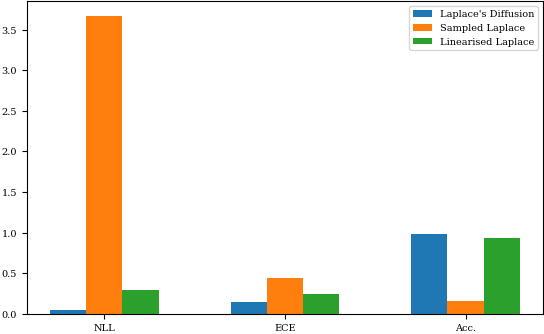

In [63]:
keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
X_axis = jnp.arange(len(keys))


plt.bar(X_axis - 0.2, Y1, 0.2, label = "Laplace's Diffusion")
plt.bar(X_axis + 0.0, Y2, 0.2, label = 'Sampled Laplace')
plt.bar(X_axis + 0.2, Y3, 0.2, label='Linearised Laplace')

plt.xticks(X_axis, keys)
plt.xlabel = keys
plt.legend()
plt.savefig('./in_distribution_metrics.pdf')


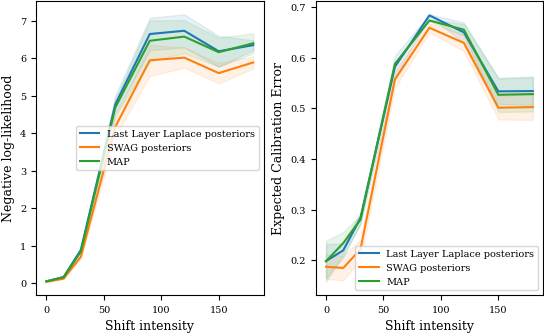

In [ ]:
fig, ax = plt.subplots(ncols=2)

uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_1 = ax[0].plot(ids, lr_metric_mean, label="Last Layer Laplace posteriors")
ax[0].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_2 = ax[0].plot(ids, lap_metric_mean, label="SWAG posteriors")
ax[0].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[0].plot(ids, map_metric_mean, label="MAP")
ax[0].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[0].set_xlabel("Shift intensity")
ax[0].set_ylabel("Negative log-likelihood")
ax[0].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Last Layer Laplace posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_2 = ax[1].plot(ids, lap_metric_mean, label="SWAG posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Expected Calibration Error")
ax[1].legend()


# plt.savefig(f"./rotated_mnist.pdf")
plt.show()

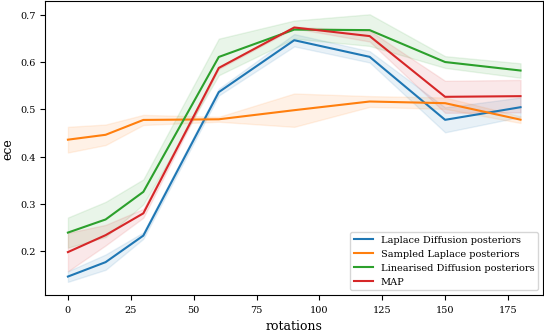

In [ ]:
uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = plt.plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
plt.fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = plt.plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
plt.fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = plt.plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
plt.fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_4 = plt.plot(ids, map_metric_mean, label="MAP")
plt.fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_4[0].get_color()
)

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()
plt.savefig(f"./rotated_mnist_{uq_metric}.pdf")


In [ ]:
results_dict = {"angles": ids, "Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised,  "MAP":metrics_map}
pickle.dump(results_dict, open("./rotated_mnist_results.pickle", "wb"))

In [ ]:
results_dict = pickle.load(open('./rotated_mnist_results.pickle', 'rb'))


In [65]:
import pandas as pd
metrics_dict = ['conf', 'nll', 'acc', 'brier', 'ece', 'mce']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "Diagonal Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla,"Diagonal Laplace": metrics_diag, "MAP":metrics_map}

df_data = {metric: ["{:.3f}".format(method_dict[dic][0][metric+'_mean']) + u"\u00B1" + "{:.3f}".format(method_dict[dic][0][metric+'_std']) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


In [66]:
method_list

['Laplace Diffusion',
 'Sampled Laplace',
 'Linearised Laplace',
 'SWAG',
 'Last-Layer Laplace',
 'Diagonal Laplace',
 'MAP']

In [67]:
metrics_dict = ['nll', 'acc', 'ece']

diffusion_dict = {k: df_data[k][0] for k in metrics_dict}
la_dict = {k: df_data[k][1] for k in metrics_dict}
lin_dict = {k: df_data[k][2] for k in metrics_dict}
swag_dict = {k: df_data[k][3] for k in metrics_dict}
llla_dict = {k: df_data[k][4] for k in metrics_dict}
map_dict = {k: df_data[k][5] for k in metrics_dict}

In [68]:
df

,conf,nll,acc,brier,ece,mce
Laplace Diffusion,0.988±0.001,0.040±0.007,0.986±0.002,0.022±0.003,0.146±0.011,0.773±0.050
Sampled Laplace,0.593±0.002,3.669±0.157,0.157±0.031,1.162±0.044,0.436±0.027,0.984±0.001
Linearised Laplace,0.967±0.002,0.295±0.041,0.930±0.004,0.111±0.006,0.239±0.032,0.862±0.044
SWAG,0.993±0.001,0.032±0.001,0.989±0.002,0.019±0.001,0.187±0.024,0.901±0.041
Last-Layer Laplace,0.991±0.001,0.047±0.003,0.987±0.002,0.021±0.001,0.198±0.034,0.721±0.091
Diagonal Laplace,0.963±0.005,0.078±0.011,0.976±0.003,0.038±0.005,0.095±0.004,0.692±0.029
MAP,0.992±0.002,0.042±0.004,0.988±0.000,0.021±0.000,0.198±0.041,0.685±0.091


In [69]:
df

,conf,nll,acc,brier,ece,mce
Laplace Diffusion,0.988±0.001,0.040±0.007,0.986±0.002,0.022±0.003,0.146±0.011,0.773±0.050
Sampled Laplace,0.593±0.002,3.669±0.157,0.157±0.031,1.162±0.044,0.436±0.027,0.984±0.001
Linearised Laplace,0.967±0.002,0.295±0.041,0.930±0.004,0.111±0.006,0.239±0.032,0.862±0.044
SWAG,0.993±0.001,0.032±0.001,0.989±0.002,0.019±0.001,0.187±0.024,0.901±0.041
Last-Layer Laplace,0.991±0.001,0.047±0.003,0.987±0.002,0.021±0.001,0.198±0.034,0.721±0.091
Diagonal Laplace,0.963±0.005,0.078±0.011,0.976±0.003,0.038±0.005,0.095±0.004,0.692±0.029
MAP,0.992±0.002,0.042±0.004,0.988±0.000,0.021±0.000,0.198±0.041,0.685±0.091


In [70]:
import pandas as pd
metrics_dict = ['nll', 'ece', 'acc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_lienarised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla, "MAP":metrics_map}

df_data = {metric: [method_dict[dic][0][metric+'_mean'] for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


In [71]:
df_data.keys()

dict_keys(['nll', 'ece', 'acc'])

In [72]:
df_data['nll']

[0.04041347652673721,
 3.668609142303467,
 0.29498153924942017,
 0.03218862786889076,
 0.04665167257189751,
 0.0424172580242157]

In [73]:
diffusion_dict = {k: df_data[k][0] for k in metrics_dict}
la_dict = {k: df_data[k][1] for k in metrics_dict}
lin_dict = {k: df_data[k][2] for k in metrics_dict}
swag_dict = {k: df_data[k][3] for k in metrics_dict}
llla_dict = {k: df_data[k][4] for k in metrics_dict}
map_dict = {k: df_data[k][5] for k in metrics_dict}

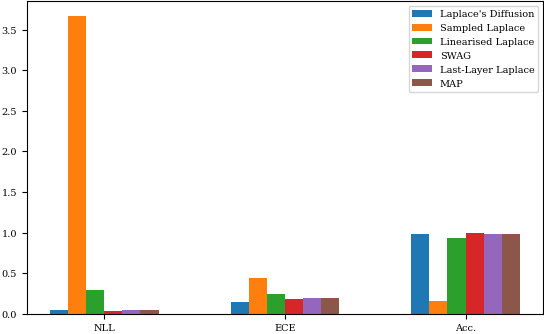

In [ ]:
keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


plt.bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
plt.bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
plt.bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
plt.bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
plt.bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
plt.bar(X_axis + 0.25, Y6, 0.1, label='MAP')

plt.xticks(X_axis, keys)
plt.xlabel = keys
plt.legend()
plt.savefig('./in_distribution_metrics.pdf')


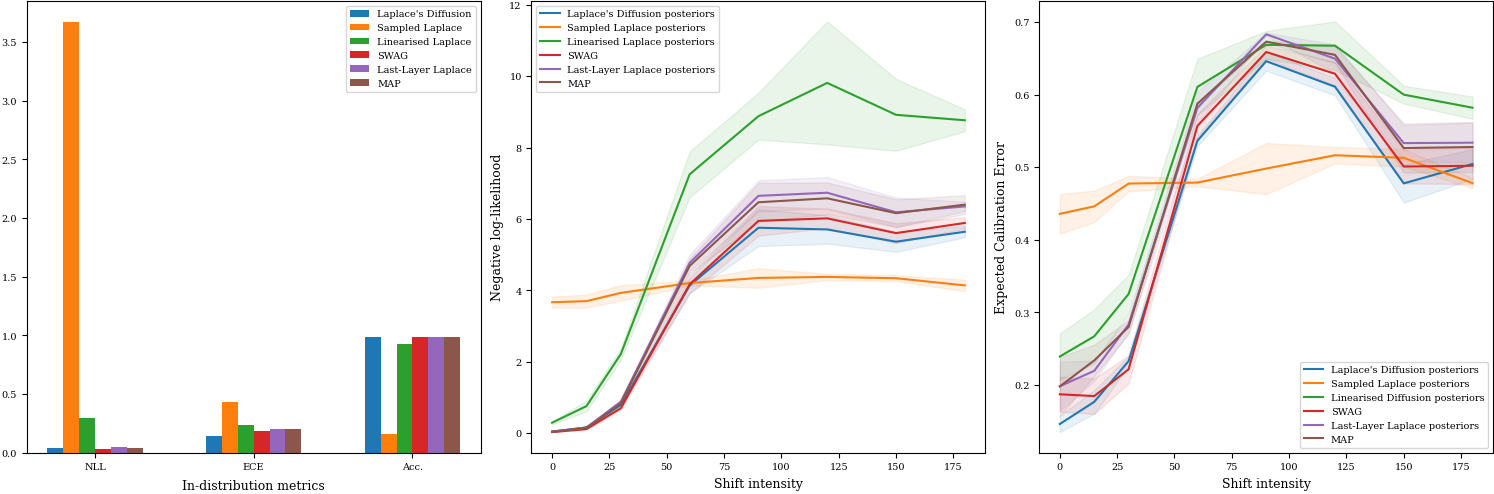

In [79]:
# fig, ax = plt.subplots(ncols=2)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
Y4 = list(swag_dict.values())
Y5 = list(llla_dict.values())
Y6 = list(map_dict.values())
X_axis = jnp.arange(len(keys))


ax[0].bar(X_axis - 0.25, Y1, 0.1, label = "Laplace's Diffusion")
ax[0].bar(X_axis - 0.15, Y2, 0.1, label = 'Sampled Laplace')
ax[0].bar(X_axis - 0.05, Y3, 0.1, label='Linearised Laplace')
ax[0].bar(X_axis + 0.05, Y4, 0.1, label='SWAG')
ax[0].bar(X_axis + 0.15, Y5, 0.1, label='Last-Layer Laplace')
ax[0].bar(X_axis + 0.25, Y6, 0.1, label='MAP')

ax[0].set_xticks(X_axis, keys)
ax[0].xlabel = keys
ax[0].legend()
ax[0].set_title("In-distribution metrics", y=-0.1)
# plt.savefig('./in_distribution_metrics.pdf')



uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)


lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[1].plot(ids, lin_metric_mean, label="SWAG")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[1].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[0].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[0].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[1].plot(ids, map_metric_mean, label="MAP")
ax[1].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)
# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Negative log-likelihood")
ax[1].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[2].plot(ids, lr_metric_mean, label="Laplace's Diffusion posteriors")
ax[2].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[2].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[2].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[2].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_swag])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_swag])
line_4 = ax[2].plot(ids, lin_metric_mean, label="SWAG")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_4[0].get_color()
)

lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_llla])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_llla])
line_5 = ax[2].plot(ids, lin_metric_mean, label="Last-Layer Laplace posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_5[0].get_color()
)

# lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_diag])
# lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_diag])
# line_6 = ax[1].plot(ids, lin_metric_mean, label="Diagonal Laplace posteriors")
# ax[1].fill_between(
#     ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_6[0].get_color()
# )


map_metric_mean = jnp.array([map[uq_metric+'_mean'] for map in metrics_map])
map_metric_std = jnp.array([map[uq_metric+'_std'] for map in metrics_map])
line_7 = ax[2].plot(ids, map_metric_mean, label="MAP")
ax[2].fill_between(
    ids, map_metric_mean - map_metric_std, map_metric_mean + map_metric_std, alpha=0.1, color=line_7[0].get_color()
)

# plt.title(uq_metric)
ax[2].set_xlabel("Shift intensity")
ax[2].set_ylabel("Expected Calibration Error")
ax[2].legend()


plt.savefig(f"./apdx_rotated_mnist.pdf")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


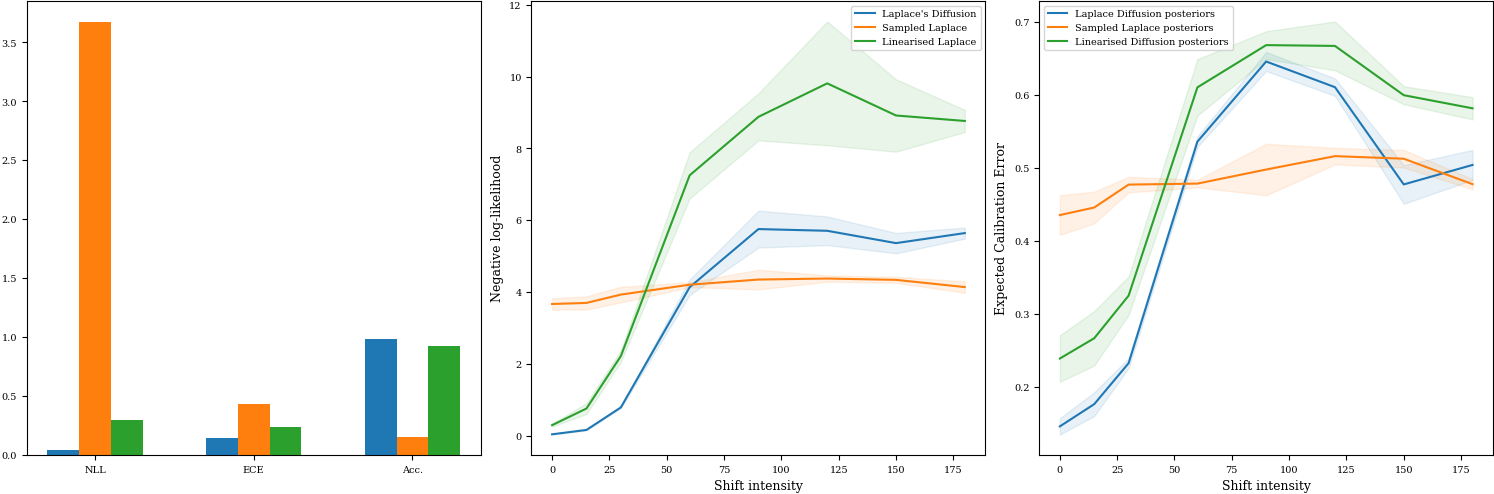

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

keys = ['NLL', 'ECE', 'Acc.']
Y1 = list(diffusion_dict.values())
Y2 = list(la_dict.values())
Y3 = list(lin_dict.values())
X_axis = jnp.arange(len(keys))


ax[0].bar(X_axis - 0.2, Y1, 0.2, label = "Laplace's Diffusion")
ax[0].bar(X_axis + 0.0, Y2, 0.2, label = 'Sampled Laplace')
ax[0].bar(X_axis + 0.2, Y3, 0.2, label='Linearised Laplace')

ax[0].set_xticks(X_axis, keys)
plt.xlabel = keys
plt.legend()


uq_metric = 'nll'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[1].plot(ids, lr_metric_mean, label="Laplace's Diffusion")
ax[1].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[1].plot(ids, lap_metric_mean, label="Sampled Laplace")
ax[1].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[1].plot(ids, lin_metric_mean, label="Linearised Laplace")
ax[1].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

# plt.title(uq_metric)
ax[1].set_xlabel("Shift intensity")
ax[1].set_ylabel("Negative log-likelihood")
ax[1].legend()

uq_metric = 'ece'
lr_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lr])
lr_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lr])
line_1 = ax[2].plot(ids, lr_metric_mean, label="Laplace Diffusion posteriors")
ax[2].fill_between(
    ids, lr_metric_mean - lr_metric_std, lr_metric_mean + lr_metric_std, alpha=0.1, color=line_1[0].get_color()
)
lap_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_posterior])
lap_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_posterior])
line_2 = ax[2].plot(ids, lap_metric_mean, label="Sampled Laplace posteriors")
ax[2].fill_between(
    ids, lap_metric_mean - lap_metric_std, lap_metric_mean + lap_metric_std, alpha=0.1, color=line_2[0].get_color()
)
lin_metric_mean = jnp.array([lr[uq_metric+'_mean'] for lr in metrics_lienarised])
lin_metric_std = jnp.array([lr[uq_metric+'_std'] for lr in metrics_lienarised])
line_3 = ax[2].plot(ids, lin_metric_mean, label="Linearised Diffusion posteriors")
ax[2].fill_between(
    ids, lin_metric_mean - lin_metric_std, lin_metric_mean + lin_metric_std, alpha=0.1, color=line_3[0].get_color()
)

# plt.title(uq_metric)
ax[2].set_xlabel("Shift intensity")
ax[2].set_ylabel("Expected Calibration Error")
ax[2].legend()


plt.savefig('./MNIST_rot.pdf')


In [ ]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  


\begin{tabular}{lllllll}
\toprule
 & conf & nll & acc & brier & ece & mce \\
\midrule
Laplace Diffusion & 0.988±0.001 & 0.040±0.007 & 0.986±0.002 & 0.022±0.003 & 0.146±0.011 & 0.773±0.050 \\
Sampled Laplace & 0.593±0.002 & 3.669±0.157 & 0.157±0.031 & 1.162±0.044 & 0.436±0.027 & 0.984±0.001 \\
Linearised Laplace & 0.967±0.002 & 0.295±0.041 & 0.930±0.004 & 0.111±0.006 & 0.239±0.032 & 0.862±0.044 \\
SWAG & 0.993±0.001 & 0.032±0.001 & 0.989±0.002 & 0.019±0.001 & 0.187±0.024 & 0.901±0.041 \\
Last-Layer Laplace & 0.991±0.001 & 0.047±0.003 & 0.987±0.002 & 0.021±0.001 & 0.198±0.034 & 0.721±0.091 \\
Diagonal Laplace & 0.963±0.005 & 0.078±0.011 & 0.976±0.003 & 0.038±0.005 & 0.095±0.004 & 0.692±0.029 \\
MAP & 0.992±0.002 & 0.042±0.004 & 0.988±0.000 & 0.021±0.000 & 0.198±0.041 & 0.685±0.091 \\
\bottomrule
\end{tabular}



### MNIST-OOD

In [38]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, lr_posterior) in enumerate(zip(param_list, lr_posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_lr.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9877, nll_mean: 0.0404, acc_mean: 0.9860, conf_std: 0.0011, nll_std: 0.0072, acc_std: 0.0016
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.8100, nll_mean: 7.7182, acc_mean: 0.0247, conf_std: 0.0313, nll_std: 0.1141, acc_std: 0.0109, auroc_mean: 0.9112, fpr95_mean: 0.3293, auroc_std: 0.0371, fpr95_std: 0.0805
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9472, nll_mean: 0.3925, acc_mean: 0.8920, conf_std: 0.0068, nll_std: 0.0366, acc_std: 0.0128, auroc_mean: 0.6294, fpr95_mean: 0.8000, auroc_std: 0.0210, fpr95_std: 0.0188
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.8166, nll_mean: 7.2543, acc_mean: 0.0827, conf_std: 0.0147, nll_std: 0.2426, acc_std: 0.0066, auroc_mean: 0.9305, fpr95_mean: 0.3820, auroc_std: 0.0088, fpr95_std: 0.0285


In [39]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_linearised = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_linearised.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_linearised[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9666, nll_mean: 0.2950, acc_mean: 0.9300, conf_std: 0.0023, nll_std: 0.0415, acc_std: 0.0043
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.8953, nll_mean: 12.1496, acc_mean: 0.0520, conf_std: 0.0268, nll_std: 1.1700, acc_std: 0.0145, auroc_mean: 0.7149, fpr95_mean: 0.8420, auroc_std: 0.0864, fpr95_std: 0.0433
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9338, nll_mean: 1.1741, acc_mean: 0.7993, conf_std: 0.0039, nll_std: 0.0644, acc_std: 0.0147, auroc_mean: 0.5358, fpr95_mean: 0.8973, auroc_std: 0.0278, fpr95_std: 0.0068
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.8628, nll_mean: 10.7925, acc_mean: 0.0913, conf_std: 0.0089, nll_std: 0.9678, acc_std: 0.0189, auroc_mean: 0.7566, fpr95_mean: 0.7627, auroc_std: 0.0175, fpr95_std: 0.0200


In [40]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_posterior = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, posterior) in enumerate(zip(param_list, posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_posterior.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_posterior[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.5932, nll_mean: 3.6686, acc_mean: 0.1567, conf_std: 0.0020, nll_std: 0.1573, acc_std: 0.0308
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.5828, nll_mean: 4.2170, acc_mean: 0.0960, conf_std: 0.0151, nll_std: 0.4208, acc_std: 0.0300, auroc_mean: 0.5149, fpr95_mean: 0.9520, auroc_std: 0.0214, fpr95_std: 0.0059
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.5836, nll_mean: 3.6081, acc_mean: 0.1480, conf_std: 0.0030, nll_std: 0.0471, acc_std: 0.0157, auroc_mean: 0.5153, fpr95_mean: 0.9353, auroc_std: 0.0043, fpr95_std: 0.0066
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.5878, nll_mean: 4.3103, acc_mean: 0.0953, conf_std: 0.0127, nll_std: 0.1100, acc_std: 0.0152, auroc_mean: 0.5072, fpr95_mean: 0.9607, auroc_std: 0.0146, fpr95_std: 0.0084


In [41]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_diag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, diag) in enumerate(zip(param_list, diag_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, diag, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_diag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_diag[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9626, nll_mean: 0.0779, acc_mean: 0.9760, conf_std: 0.0053, nll_std: 0.0110, acc_std: 0.0028
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.7696, nll_mean: 6.1188, acc_mean: 0.0373, conf_std: 0.0258, nll_std: 0.2807, acc_std: 0.0034, auroc_mean: 0.8660, fpr95_mean: 0.6313, auroc_std: 0.0302, fpr95_std: 0.0469
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9068, nll_mean: 0.4304, acc_mean: 0.8693, conf_std: 0.0052, nll_std: 0.0330, acc_std: 0.0077, auroc_mean: 0.6166, fpr95_mean: 0.8667, auroc_std: 0.0095, fpr95_std: 0.0106
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.7473, nll_mean: 5.5994, acc_mean: 0.0807, conf_std: 0.0132, nll_std: 0.1525, acc_std: 0.0066, auroc_mean: 0.8970, fpr95_mean: 0.5853, auroc_std: 0.0053, fpr95_std: 0.0328


In [42]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_swag = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, swag_posterior) in enumerate(zip(param_list, swag_posterior_list)):    
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, swag_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_swag.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_swag[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9927, nll_mean: 0.0322, acc_mean: 0.9887, conf_std: 0.0008, nll_std: 0.0014, acc_std: 0.0019
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.8270, nll_mean: 7.6312, acc_mean: 0.0293, conf_std: 0.0541, nll_std: 0.5063, acc_std: 0.0090, auroc_mean: 0.9489, fpr95_mean: 0.2513, auroc_std: 0.0178, fpr95_std: 0.1022
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9552, nll_mean: 0.3492, acc_mean: 0.9073, conf_std: 0.0042, nll_std: 0.0077, acc_std: 0.0025, auroc_mean: 0.6272, fpr95_mean: 0.7713, auroc_std: 0.0158, fpr95_std: 0.0175
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.8227, nll_mean: 7.4349, acc_mean: 0.0833, conf_std: 0.0128, nll_std: 0.1127, acc_std: 0.0057, auroc_mean: 0.9472, fpr95_mean: 0.2847, auroc_std: 0.0070, fpr95_std: 0.0321


In [43]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_llla = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, (params, ll_posterior) in enumerate(zip(param_list, last_layer_list)):   
        _, test_loader = get_mnist_ood_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, ll_posterior, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_llla.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_llla[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9912, nll_mean: 0.0467, acc_mean: 0.9873, conf_std: 0.0015, nll_std: 0.0034, acc_std: 0.0019
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.8417, nll_mean: 9.0964, acc_mean: 0.0280, conf_std: 0.0458, nll_std: 0.4584, acc_std: 0.0033, auroc_mean: 0.9036, fpr95_mean: 0.3627, auroc_std: 0.0325, fpr95_std: 0.1225
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9580, nll_mean: 0.4468, acc_mean: 0.8953, conf_std: 0.0047, nll_std: 0.0486, acc_std: 0.0123, auroc_mean: 0.6249, fpr95_mean: 0.7833, auroc_std: 0.0284, fpr95_std: 0.0146
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.8368, nll_mean: 8.0971, acc_mean: 0.0833, conf_std: 0.0088, nll_std: 0.2256, acc_std: 0.0025, auroc_mean: 0.9349, fpr95_mean: 0.2940, auroc_std: 0.0044, fpr95_std: 0.0140


In [44]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "EMNIST", "KMNIST"]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    some_metrics_all = defaultdict(list)
    more_metrics_all = defaultdict(list)
    for seed, params in enumerate(param_list):   
        # params = params_dict['params'] 
        _, test_loader = get_mnist_ood_loaders(id, data_path="./data/", download=False, batch_size=ood_batch_size, n_datapoint=n_datapoint)
        some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args, False)
        if i == 0:
            all_y_prob_in = all_y_prob
        more_metrics = compute_metrics(
                i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
            )
        for k, v in some_metrics.items():
            some_metrics_all[k].append(v)
        for k, v in more_metrics.items():   
            more_metrics_all[k].append(v)
    seed_some_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in some_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in some_metrics_all.items()}}
    seed_more_metric =  {**{k+"_mean": jnp.mean(jnp.array(v)).item() for k, v in more_metrics_all.items()}, **{k+"_std": jnp.std(jnp.array(v)).item() for k, v in more_metrics_all.items()}}
    metrics_map.append({**seed_some_metric, **seed_more_metric})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
MNIST-OOD - dataset: MNIST
conf_mean: 0.9919, nll_mean: 0.0424, acc_mean: 0.9880, conf_std: 0.0019, nll_std: 0.0037, acc_std: 0.0000
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
MNIST-OOD - dataset: FMNIST
conf_mean: 0.8505, nll_mean: 8.8914, acc_mean: 0.0307, conf_std: 0.0354, nll_std: 0.1994, acc_std: 0.0038, auroc_mean: 0.9067, fpr95_mean: 0.3240, auroc_std: 0.0379, fpr95_std: 0.0836
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
MNIST-OOD - dataset: EMNIST
conf_mean: 0.9590, nll_mean: 0.4063, acc_mean: 0.8980, conf_std: 0.0053, nll_std: 0.0434, acc_std: 0.0156, auroc_mean: 0.6341, fpr95_mean: 0.7840, auroc_std: 0.0188, fpr95_std: 0.0166
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
MNIST-OOD - dataset: KMNIST
conf_mean: 0.8368, nll_mean: 8.0596, acc_mean: 0.0847, conf_std: 0.0097, nll_std: 0.1853, acc_std: 0.0034, auroc_mean: 0.9378, fpr95_mean: 0.3027, auroc_std: 0.0057, fpr95_std: 0.0333


In [45]:
import pandas as pd
metrics_dict = ['conf', 'auroc']
method_list = ["Laplace Diffusion", "Sampled Laplace", "Linearised Laplace", "SWAG", "Last-Layer Laplace", "Diagonal Laplace", "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "Sampled Laplace": metrics_posterior,"Linearised Laplace":metrics_linearised, "SWAG": metrics_swag,
               "Last-Layer Laplace":metrics_llla,"Diagonal Laplace": metrics_diag, "MAP":metrics_map}
mux = pd.MultiIndex.from_product([ids[1:], metrics_dict])
# df_data = {k: [dic[metric+'_mean'] for metric in metrics_dict for dic in method_dict[k][1:]] for k in method_dict}
df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index',
                       columns=mux)


In [46]:
df

FMNIST                    EMNIST               \
                           conf        auroc         conf        auroc   
Laplace Diffusion   0.810±0.031  0.911±0.037  0.947±0.007  0.629±0.021   
Sampled Laplace     0.583±0.015  0.515±0.021  0.584±0.003  0.515±0.004   
Linearised Laplace  0.895±0.027  0.715±0.086  0.934±0.004  0.536±0.028   
SWAG                0.827±0.054  0.949±0.018  0.955±0.004  0.627±0.016   
Last-Layer Laplace  0.842±0.046  0.904±0.033  0.958±0.005  0.625±0.028   
Diagonal Laplace    0.770±0.026  0.866±0.030  0.907±0.005  0.617±0.009   
MAP                 0.850±0.035  0.907±0.038  0.959±0.005  0.634±0.019   

                         KMNIST               
                           conf        auroc  
Laplace Diffusion   0.817±0.015  0.930±0.009  
Sampled Laplace     0.588±0.013  0.507±0.015  
Linearised Laplace  0.863±0.009  0.757±0.018  
SWAG                0.823±0.013  0.947±0.007  
Last-Layer Laplace  0.837±0.009  0.935±0.004  
Diagonal Laplace    0.747±0.013  0.897±0.005  
MAP                 0.837±0.010  0.938±0.006

In [47]:
print(df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,
))  


\begin{tabular}{lllllll}
\toprule
 & \multicolumn{2}{r}{FMNIST} & \multicolumn{2}{r}{EMNIST} & \multicolumn{2}{r}{KMNIST} \\
 & conf & auroc & conf & auroc & conf & auroc \\
\midrule
Laplace Diffusion & 0.810±0.031 & 0.911±0.037 & 0.947±0.007 & 0.629±0.021 & 0.817±0.015 & 0.930±0.009 \\
Sampled Laplace & 0.583±0.015 & 0.515±0.021 & 0.584±0.003 & 0.515±0.004 & 0.588±0.013 & 0.507±0.015 \\
Linearised Laplace & 0.895±0.027 & 0.715±0.086 & 0.934±0.004 & 0.536±0.028 & 0.863±0.009 & 0.757±0.018 \\
SWAG & 0.827±0.054 & 0.949±0.018 & 0.955±0.004 & 0.627±0.016 & 0.823±0.013 & 0.947±0.007 \\
Last-Layer Laplace & 0.842±0.046 & 0.904±0.033 & 0.958±0.005 & 0.625±0.028 & 0.837±0.009 & 0.935±0.004 \\
Diagonal Laplace & 0.770±0.026 & 0.866±0.030 & 0.907±0.005 & 0.617±0.009 & 0.747±0.013 & 0.897±0.005 \\
MAP & 0.850±0.035 & 0.907±0.038 & 0.959±0.005 & 0.634±0.019 & 0.837±0.010 & 0.938±0.006 \\
\bottomrule
\end{tabular}



| Laplace Diffusion | 0.809±0.027 | 0.909±0.033 | 0.948±0.006 | 0.625±0.018 | 0.816±0.013 | 0.929±0.008 | 
| Laplace Approximation | 0.576±0.017 | 0.500±0.026 | 0.582±0.004 | 0.494±0.006 | 0.588±0.011 | 0.482±0.013 |
| Linearised Laplace | 0.899±0.024 | 0.758±0.070 | 0.935±0.004 | 0.602±0.027 | 0.865±0.009 | 0.790±0.018 |
| MAP & 0.856±0.032 | 0.916±0.033 | 0.960±0.005 | 0.649±0.017 | 0.838±0.009 | 0.940±0.005 |
